### MOUNT DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#what do we have now
!ls /content/drive/MyDrive/'Colab Notebooks'/cdcxyhills_2025

 feature_names.npy		        test_processed_tab.npy
 images				       'train(1).csv'
 model_training.ipynb		        train_dedup.csv
 preprocessing.ipynb		        X_train.csv
 preprocess_notebook_requirements.txt   X_train_processed_tab.npy
 preprocessor.pkl		        X_val.csv
 row_ids_train.npy		        X_val_processed_tab.npy
 row_ids_val.npy		        y_train_log_tab.npy
'test(2).csv'			        y_val_log_tab.npy
 test_df_row_ids.npy		        zip_rank_mapping.pkl


In [3]:
import torch
torch.cuda.is_available()

True

# 1.TRAIN-tabular model

### LOAD-libraries

In [4]:
#data handling
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#save and load
import joblib

#explainability
import shap

#model
from xgboost import XGBRegressor

### LOAD-processed data

In [5]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025"

#train data
X_train = np.load(f"{BASE_DIR}/X_train_processed_tab.npy")
X_val   = np.load(f"{BASE_DIR}/X_val_processed_tab.npy")

y_train_log = np.load(f"{BASE_DIR}/y_train_log_tab.npy")
y_val_log   = np.load(f"{BASE_DIR}/y_val_log_tab.npy")

In [6]:
X_train.shape , X_val.shape

((12888, 23), (3222, 23))

### MODEL-XGB

In [7]:
#the best among previously grid tested parameters
best_params = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 1.5,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "n_jobs": -1,
    "random_state": 42,
}

tab_model = XGBRegressor(**best_params)


In [ ]:
#train model
tab_model.fit(X_train, y_train_log)

In [9]:
#predict
Y_val_preds_log = tab_model.predict(X_val)

#back transform
Y_val_preds = np.expm1(Y_val_preds_log)
Y_val = np.expm1(y_val_log)

In [10]:
#evaluate on original price scale
mse = mean_squared_error(Y_val, Y_val_preds)
rmse = np.sqrt(mse)
r2 = r2_score(Y_val, Y_val_preds)

metrics = {
    "mse": mse,
    "rmse": rmse,
    "r2": r2,
}

print("Tabular model Metrics")
print(metrics)

Tabular model Metrics
{'mse': 10958010899.57446, 'rmse': np.float64(104680.51824276788), 'r2': 0.9103577342228578}


In [11]:
#save model and metrics
joblib.dump(tab_model, f"{BASE_DIR}/xgb_tabular_baseline.pkl")
joblib.dump(metrics, f"{BASE_DIR}/xgb_tabular_baseline_metrics.pkl")


['/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025/xgb_tabular_baseline_metrics.pkl']

### Explainability

#### Feature Importance

In [12]:
#load feature names
feature_names = np.load(f"{BASE_DIR}/feature_names.npy", allow_pickle=True)

In [13]:
#get importances
importances = tab_model.feature_importances_

feat_imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances,
    })
    .sort_values("importance", ascending=False)
)

In [14]:
feat_imp_df

feature  importance
22         binary__zip_rank    0.279873
11             scale__grade    0.262939
2         skew__sqft_living    0.124161
20  binary__is_premium_view    0.065874
17       binary__waterfront    0.058005
6                skew__view    0.046560
12               scale__lat    0.034415
13              scale__long    0.014172
21        binary__sale_year    0.012826
10         scale__condition    0.011681
14         scale__house_age    0.011371
3       skew__sqft_living15    0.011266
4          skew__sqft_above    0.011156
8          scale__bathrooms    0.008668
1          skew__sqft_lot15    0.007340
18    binary__was_renovated    0.007002
0            skew__sqft_lot    0.006615
19    binary__is_luxury_bed    0.006376
16      scale__sale_quarter    0.005114
7           scale__bedrooms    0.003815
9             scale__floors    0.003741
5       skew__sqft_basement    0.003675
15        scale__sale_month    0.003357

In [ ]:
#plot
feat_imp_df.plot(
    x="feature",
    y="importance",
    kind="barh",
    figsize=(8, 6),
    title="XGBoost Feature Importance (Top 20)",
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**OBSERVATION**

| Rank | Feature | Importance | Interpretation |
|------|---------|------------|----------------|
| 1 |   zip_rank | 0.27	 | Location dominates
| 2 | grade	|0.26	|Construction / finish quality
| 3 | sqft_living|	0.12 |	Size still matters
| 4 |   lat | 	0.03 | secondary performer
| 5 | view	|0.04	| secondary performer
| 6 | is_premium_view|0.06 |	secondary performer
| 7 |   waterfront | 	0.05 | secondary performer

* month , basement , scale__floors,scale__bedrooms performed very poor

In [16]:
#save feature imp
feat_imp_df.to_csv(f"{BASE_DIR}/xgb_feature_importance.csv", index=False)

# 2.GET- image embeddings

#### LOAD-libraries

In [17]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import timm
from tqdm import tqdm
from torch.amp import autocast

In [18]:
!ls /content/drive/MyDrive/'Colab Notebooks'/cdcxyhills_2025/

 feature_names.npy		        train_dedup.csv
 images				        xgb_feature_importance.csv
 model_training.ipynb		        xgb_tabular_baseline_metrics.pkl
 preprocessing.ipynb		        xgb_tabular_baseline.pkl
 preprocess_notebook_requirements.txt   X_train.csv
 preprocessor.pkl		        X_train_processed_tab.npy
 row_ids_train.npy		        X_val.csv
 row_ids_val.npy		        X_val_processed_tab.npy
'test(2).csv'			        y_train_log_tab.npy
 test_df_row_ids.npy		        y_val_log_tab.npy
 test_processed_tab.npy		        zip_rank_mapping.pkl
'train(1).csv'


#### Extract ( Efficient net )

**Config**

In [19]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025"

IMG_DIR_TRAIN = Path(f"{BASE_DIR}/images/train")

TRAIN_CSV = f"{BASE_DIR}/X_train.csv"
VAL_CSV   = f"{BASE_DIR}/X_val.csv"

ROW_IDS_TRAIN = f"{BASE_DIR}/row_ids_train.npy"
ROW_IDS_VAL   = f"{BASE_DIR}/row_ids_val.npy"

IMAGE_SIZE = 384
BATCH_SIZE = 32
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#model (efficientnet_b0)
model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=0
).to(DEVICE)

model.eval()

**fun def**

In [21]:
#data set
class ImageDataset(Dataset):
    def __init__(self, ids, image_dir):
        self.ids = ids.astype(str)
        self.image_dir = image_dir

        self.transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
            ),
        ])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img = Image.open(self.image_dir / f"{img_id}.jpg").convert("RGB")
        img = self.transform(img)
        return img, img_id

#embeddings
def generate_embeddings(ids, image_dir, out_prefix):
    ds = ImageDataset(ids, image_dir)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS,pin_memory=True)

    all_emb, all_ids = [], []

    with torch.no_grad():
        for imgs, batch_ids in tqdm(loader, desc=f"Embedding {out_prefix}"):
            imgs = imgs.to(DEVICE)
            with autocast(device_type='cuda'):
              emb = model(imgs)
            all_emb.append(emb.cpu().numpy())
            all_ids.extend(batch_ids)

    all_emb = np.vstack(all_emb)
    all_ids = np.array(all_ids)

    np.save(f"{BASE_DIR}/{out_prefix}_emb.npy", all_emb)
    np.save(f"{BASE_DIR}/{out_prefix}_ids.npy", all_ids)

    print(out_prefix, all_emb.shape)



**Extraction**

In [ ]:
#load ids
train_ids = np.load(ROW_IDS_TRAIN)
val_ids   = np.load(ROW_IDS_VAL)

#generate embeddings
generate_embeddings(train_ids, IMG_DIR_TRAIN, "img_train")
generate_embeddings(val_ids,   IMG_DIR_TRAIN, "img_val")

In [23]:
check = np.load(f"{BASE_DIR}/img_train_ids.npy")

In [24]:
#check types
print(check.dtype)
print(train_ids.dtype)

<U10
int64


In [25]:
check.shape

(12888,)

In [26]:
img_train_ids = np.load(f"{BASE_DIR}/img_train_ids.npy").astype(str)
train_ids     = np.load(f"{BASE_DIR}/row_ids_train.npy").astype(str)

val_img_ids = np.load(f"{BASE_DIR}/img_val_ids.npy").astype(str)
val_ids     = np.load(f"{BASE_DIR}/row_ids_val.npy").astype(str)


assert np.array_equal(img_train_ids, train_ids)
assert np.array_equal(val_img_ids, val_ids)

print(" Embedding alignment verified.")


 Embedding alignment verified.


# 3.TRAIN-MULTI(Early-fusion)model

### CONFIGURE

In [27]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025"

# tabular
X_train_tab = np.load(f"{BASE_DIR}/X_train_processed_tab.npy")
X_val_tab   = np.load(f"{BASE_DIR}/X_val_processed_tab.npy")
y_train_log = np.load(f"{BASE_DIR}/y_train_log_tab.npy")
y_val_log   = np.load(f"{BASE_DIR}/y_val_log_tab.npy")

# image embeddings (aligned by row order)
img_train = np.load(f"{BASE_DIR}/img_train_emb.npy")
img_val   = np.load(f"{BASE_DIR}/img_val_emb.npy")


### PCA

In [28]:
#pca 180 dim
from sklearn.decomposition import PCA

PCA_DIM = 180

pca = PCA(n_components=PCA_DIM, random_state=42)
img_train_pca = pca.fit_transform(img_train)
img_val_pca   = pca.transform(img_val)

print("Explained variance (sum):", pca.explained_variance_ratio_.sum())

Explained variance (sum): 0.903319948474181


In [29]:
#save pca
joblib.dump(pca, f"{BASE_DIR}/img_pca_180.pkl")

['/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025/img_pca_180.pkl']

**load and align data**

In [30]:
#fuse the data
X_train_fused = np.hstack([X_train_tab, img_train_pca])
X_val_fused   = np.hstack([X_val_tab,   img_val_pca])

print(X_train_fused.shape, X_val_fused.shape)


(12888, 203) (3222, 203)


### Train - regularized XGBoost

In [31]:
xgb_early = XGBRegressor(
    n_estimators=400,
    max_depth=5,          #  to avoid image noise
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=2.0,
    min_child_weight=5,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

In [ ]:
#fit
xgb_early.fit(X_train_fused, y_train_log)

In [33]:
#predict
Y_val_preds_log = xgb_early.predict(X_val_fused)

**Evaluate**

In [34]:
#back transform
Y_val_preds = np.expm1(Y_val_preds_log)
Y_val = np.expm1(y_val_log)

#evaluate
mse = mean_squared_error(Y_val, Y_val_preds)
rmse = np.sqrt(mse)
r2 = r2_score(Y_val, Y_val_preds)

metrics = {
    "mse": mse,
    "rmse": rmse,
    "r2": r2,
}

print("Early Fusion XGB Metrics")
print(metrics)

Early Fusion XGB Metrics
{'mse': 11671714031.678019, 'rmse': np.float64(108035.70720682129), 'r2': 0.9045192689721534}


**Save artifacts**

In [35]:
#save
joblib.dump(xgb_early, f"{BASE_DIR}/xgb_early_fusion.pkl")
joblib.dump(metrics, f"{BASE_DIR}/xgb_early_fusion_metrics.pkl")

['/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025/xgb_early_fusion_metrics.pkl']

### ANALYSIS - feature importance

In [36]:
# Load model
model = xgb_early  # PCA-180 model

# Build feature names
n_tab = X_train_tab.shape[1]
n_img = img_train_pca.shape[1]  # 180

tab_features = np.load(f"{BASE_DIR}/feature_names.npy",allow_pickle=True).tolist()
img_features = [f"img_pca_{i}" for i in range(n_img)]

feature_names = tab_features + img_features

# Importance
imp = model.feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": imp
}).sort_values("importance", ascending=False)



In [37]:
tab_imp = imp_df[imp_df.feature.isin(tab_features)]["importance"].sum()
img_imp = imp_df[imp_df.feature.str.startswith("img_pca_")]["importance"].sum()

tab_imp, img_imp, img_imp / (tab_imp + img_imp)


(np.float32(0.7476285), np.float32(0.25237158), np.float32(0.25237155))

In [38]:
imp_df[imp_df.feature.str.startswith("img_pca_")].head(15)


feature  importance
111   img_pca_88    0.002261
28     img_pca_5    0.002165
27     img_pca_4    0.002158
48    img_pca_25    0.002018
114   img_pca_91    0.002018
169  img_pca_146    0.002013
64    img_pca_41    0.001995
49    img_pca_26    0.001995
23     img_pca_0    0.001969
26     img_pca_3    0.001965
59    img_pca_36    0.001956
101   img_pca_78    0.001952
155  img_pca_132    0.001918
184  img_pca_161    0.001908
93    img_pca_70    0.001896

In [ ]:
explainer = shap.TreeExplainer(xgb_early)
shap_values = explainer.shap_values(X_val_fused)

shap.summary_plot(shap_values, X_val_fused, feature_names=feature_names)


# 4.TRAIN-MULTI(Late-fusion)model

### LOAD - libraries and data

In [40]:
#libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

In [41]:
#data
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025"

# Tabular features
X_train_tab = np.load(f"{BASE_DIR}/X_train_processed_tab.npy")
X_val_tab   = np.load(f"{BASE_DIR}/X_val_processed_tab.npy")

# Targets (log scale)
y_train_log = np.load(f"{BASE_DIR}/y_train_log_tab.npy")
y_val_log   = np.load(f"{BASE_DIR}/y_val_log_tab.npy")

# Image embeddings after PCA (180 dims)
pca = joblib.load(f"{BASE_DIR}/img_pca_180.pkl")

#get
img_train_pca = pca.transform(np.load(f"{BASE_DIR}/img_train_emb.npy"))
img_val_pca   = pca.transform(np.load(f"{BASE_DIR}/img_val_emb.npy"))

print(
    X_train_tab.shape,
    img_train_pca.shape,
    y_train_log.shape
)

(12888, 23) (12888, 180) (12888,)


In [42]:
#sanity check
assert X_train_tab.shape[0] == img_train_pca.shape[0] == y_train_log.shape[0]
assert X_val_tab.shape[0] == img_val_pca.shape[0] == y_val_log.shape[0]

**Define**

In [43]:
#dataset
class LateFusionDataset(Dataset):
    def __init__(self, X_tab, X_img, y):
        self.X_tab = torch.tensor(X_tab, dtype=torch.float32)
        self.X_img = torch.tensor(X_img, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_tab[idx], self.X_img[idx], self.y[idx]



#late fusion model
class LateFusionMLP(nn.Module):
    def __init__(self, tab_dim, img_dim=180):
        super().__init__()

        # tabular branch
        self.tab_branch = nn.Sequential(
            nn.Linear(tab_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        # image branch (PCA-compressed)
        self.img_branch = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        # fusion head
        self.fusion = nn.Sequential(
            nn.Linear(64 + 128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

    def forward(self, x_tab, x_img):
        t = self.tab_branch(x_tab)
        i = self.img_branch(x_img)
        x = torch.cat([t, i], dim=1)
        return self.fusion(x).squeeze(1)


    def forward(self, x_tab, x_img):
        tab_emb = self.tab_branch(x_tab)
        img_emb = self.img_branch(x_img)
        x = torch.cat([tab_emb, img_emb], dim=1)
        return self.fusion(x).squeeze(1)



### TRAIN - Late fusion model

In [44]:
#configure
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = LateFusionDataset(
    X_train_tab, img_train_pca, y_train_log
)
val_ds = LateFusionDataset(
    X_val_tab, img_val_pca, y_val_log
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)


In [45]:
late_fusion_model = LateFusionMLP(tab_dim=X_train_tab.shape[1]).to(DEVICE)
optimizer = Adam(late_fusion_model.parameters(), lr=1e-3)
criterion = MSELoss()

In [46]:
#train (20 epochs)
for epoch in range(20):
    late_fusion_model.train()
    for x_tab, x_img, y in train_loader:
        x_tab, x_img, y = x_tab.to(DEVICE), x_img.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(late_fusion_model(x_tab, x_img), y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Train MSE: {loss.item():.4f}")


Epoch 1 | Train MSE: 3.9127
Epoch 2 | Train MSE: 2.9682
Epoch 3 | Train MSE: 1.6681
Epoch 4 | Train MSE: 1.8642
Epoch 5 | Train MSE: 1.4068
Epoch 6 | Train MSE: 1.7791
Epoch 7 | Train MSE: 1.1143
Epoch 8 | Train MSE: 1.3726
Epoch 9 | Train MSE: 2.0550
Epoch 10 | Train MSE: 1.5357
Epoch 11 | Train MSE: 1.5091
Epoch 12 | Train MSE: 0.8134
Epoch 13 | Train MSE: 1.0449
Epoch 14 | Train MSE: 0.9493
Epoch 15 | Train MSE: 0.9505
Epoch 16 | Train MSE: 1.2359
Epoch 17 | Train MSE: 0.9350
Epoch 18 | Train MSE: 1.2611
Epoch 19 | Train MSE: 1.1006
Epoch 20 | Train MSE: 0.5560


### Evaluate

In [47]:
late_fusion_model.eval()
preds, ys = [], []

with torch.no_grad():
    for x_tab, x_img, y in val_loader:
        p = late_fusion_model(x_tab.to(DEVICE), x_img.to(DEVICE))
        preds.append(p.cpu().numpy())
        ys.append(y.numpy())

preds = np.concatenate(preds)
ys = np.concatenate(ys)

y_pred_price = np.expm1(preds)
y_true_price = np.expm1(ys)

In [48]:
#metrics

metrics={
    "mse": mean_squared_error(y_true_price, y_pred_price),
    "rmse": np.sqrt(mean_squared_error(y_true_price, y_pred_price)),
    "r2": r2_score(y_true_price, y_pred_price)
}


print("Late Fusion Model Metrics")
print(metrics)

Late Fusion Model Metrics
{'mse': 38779498496.0, 'rmse': np.float64(196925.10885105535), 'r2': 0.682763397693634}


In [49]:
#save late fusion model
torch.save(late_fusion_model.state_dict(), f"{BASE_DIR}/late_fusion_model.pth")

# 5.GRAD - CAM VIZ

In [50]:
import torch.nn.functional as F
import timm
from torchvision import transforms
from PIL import Image
from pathlib import Path

In [51]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025"
IMG_DIR = Path(f"{BASE_DIR}/images/train")

In [ ]:
model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=0
).to(DEVICE)

model.eval()


In [53]:
#gradcam
class GradCAM:
    def __init__(self, model, target_layer):
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self):
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam


In [54]:
gradcam = GradCAM(model, model.conv_head)

In [55]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

In [56]:
def run_gradcam(image_id):
    img_path = IMG_DIR / f"{image_id}.jpg"
    img = Image.open(img_path).convert("RGB")

    x = transform(img).unsqueeze(0).to(DEVICE)
    x.requires_grad = True

    emb = model(x)
    score = emb.norm()      # proxy objective
    score.backward()

    cam = gradcam.generate()[0].detach().cpu().numpy()
    cam = np.uint8(255 * cam)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.imshow(cam, cmap="jet", alpha=0.45)
    plt.title(f"Grad-CAM — ID {image_id}")
    plt.axis("off")
    plt.show()

In [57]:
#load early fusion model
xgb_early = joblib.load(f"{BASE_DIR}/xgb_early_fusion.pkl")

# Predict on validation
y_val_log_pred = xgb_early.predict(X_val_fused)

y_val_pred = np.expm1(y_val_log_pred)
y_val_true = np.expm1(y_val_log)

# Absolute error (price scale)
abs_err = np.abs(y_val_pred - y_val_true)

# Best (lowest error)
best_idx = np.argsort(abs_err)[:3]

# Worst (highest error)
worst_idx = np.argsort(abs_err)[-3:]


In [58]:
#map indices
val_ids = np.load(f"{BASE_DIR}/row_ids_val.npy")

best_ids = val_ids[best_idx]
worst_ids = val_ids[worst_idx]

best_ids, worst_ids

(array([3862700020, 3862710210, 9347300160]),
 array([ 333100295, 6072800170, 1924059029]))

In [ ]:
run_gradcam(best_ids[0])

In [ ]:
#check for best preforming ids
for pid in best_ids[:3]:
    run_gradcam(pid)

In [ ]:
#check for worst perf ids
for pid in worst_ids[:3]:
    run_gradcam(pid)

### Overlay and Analyze

In [62]:
import cv2

In [63]:
def normalize_cam(cam):
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    return cam


In [64]:
def run_gradcam_pub(image_id, save_path=None):
    img_path = IMG_DIR / f"{image_id}.jpg"
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    x = transform(img).unsqueeze(0).to(DEVICE)
    x.requires_grad = True

    emb = model(x)
    score = emb.norm()
    score.backward()

    cam = gradcam.generate()[0].detach().cpu().numpy()
    cam = normalize_cam(cam)

    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_resized), cv2.COLORMAP_JET
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = np.clip(
        0.6 * img_np + 0.4 * heatmap, 0, 255
    ).astype(np.uint8)

    # ---- Plot ----
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))

    axes[0].imshow(img_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(cam_resized, cmap="jet")
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.suptitle(f"Grad-CAM Visualization (ID: {image_id})", fontsize=14)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


In [ ]:
#best performers
for pid in best_ids:
    run_gradcam_pub(
        pid,
        save_path=f"{BASE_DIR}/gradcam_best_{pid}.png"
    )

In [ ]:
#worst performerss
for pid in worst_ids:
    run_gradcam_pub(
        pid,
        save_path=f"{BASE_DIR}/gradcam_worst_{pid}.png"
    )

### CHECK(+ve and -ve price drivers)

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(
    xgb_early,
    importance_type="gain",   # BEST for interpretation
    max_num_features=15
)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()


In [68]:
import numpy as np
import pandas as pd

# img_train_pca: (n_train, 180)
# y_train_log: log(price)

img_pca = img_train_pca
price = np.expm1(y_train_log)  # back to price scale

corrs = [
    np.corrcoef(img_pca[:, i], price)[0, 1]
    for i in range(img_pca.shape[1])
]

corr_df = pd.DataFrame({
    "pca_component": range(len(corrs)),
    "corr_with_price": corrs
}).sort_values("corr_with_price", ascending=False)

corr_df.head(10)


pca_component  corr_with_price
4               4         0.200873
3               3         0.189639
12             12         0.113805
28             28         0.111984
21             21         0.102915
15             15         0.100014
10             10         0.082636
43             43         0.080538
7               7         0.080372
18             18         0.077539

In [69]:
top_pos = corr_df.head(3)["pca_component"].tolist()
top_neg = corr_df.tail(3)["pca_component"].tolist()

top_pos, top_neg


([4, 3, 12], [11, 9, 20])

In [70]:
len(top_pos), len(top_neg)

(3, 3)

In [71]:
def show_top_images_for_component(comp_idx, top_k=5):
    scores = img_train_pca[:, comp_idx]
    top_idx = np.argsort(scores)[-top_k:]

    ids = np.load(f"{BASE_DIR}/row_ids_train.npy")[top_idx]

    for pid in ids:
        run_gradcam_pub(pid)


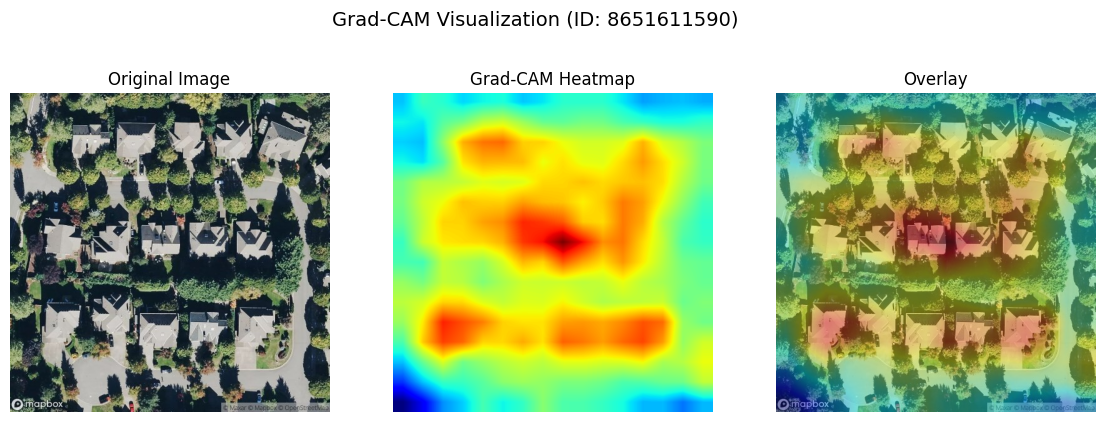

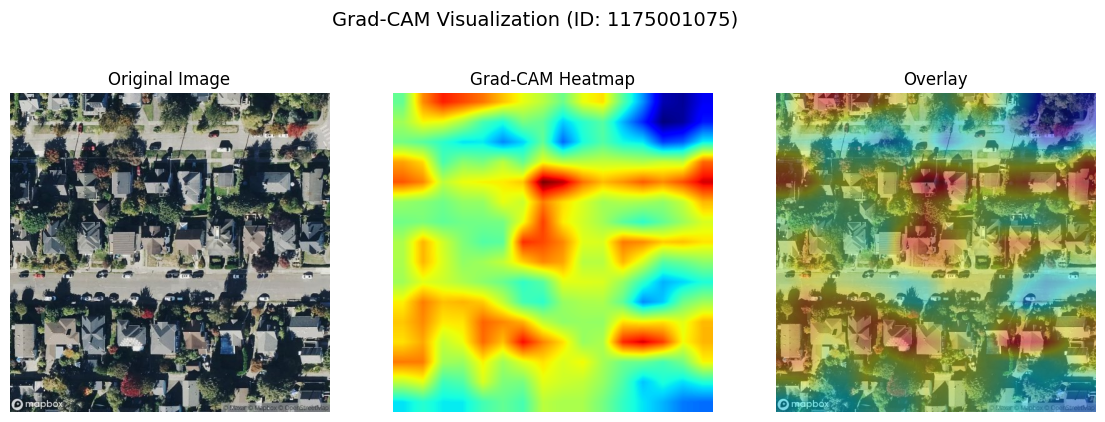

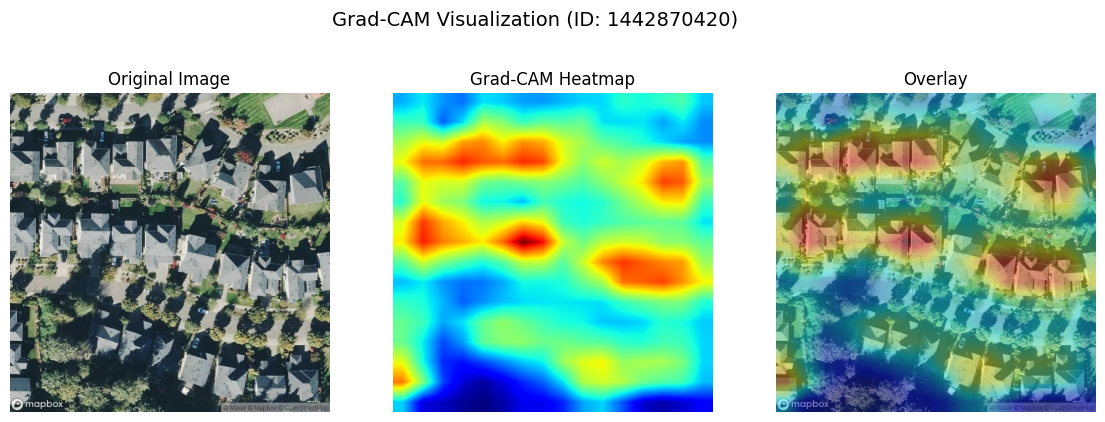

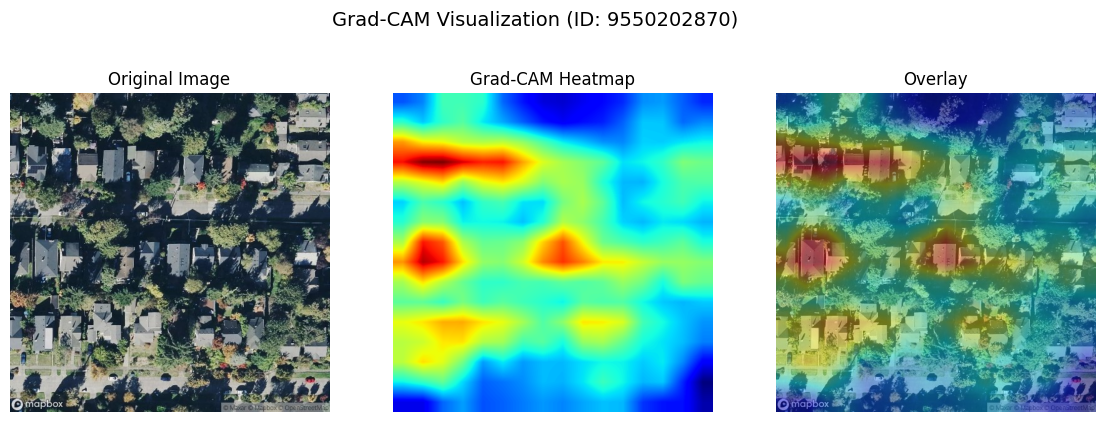

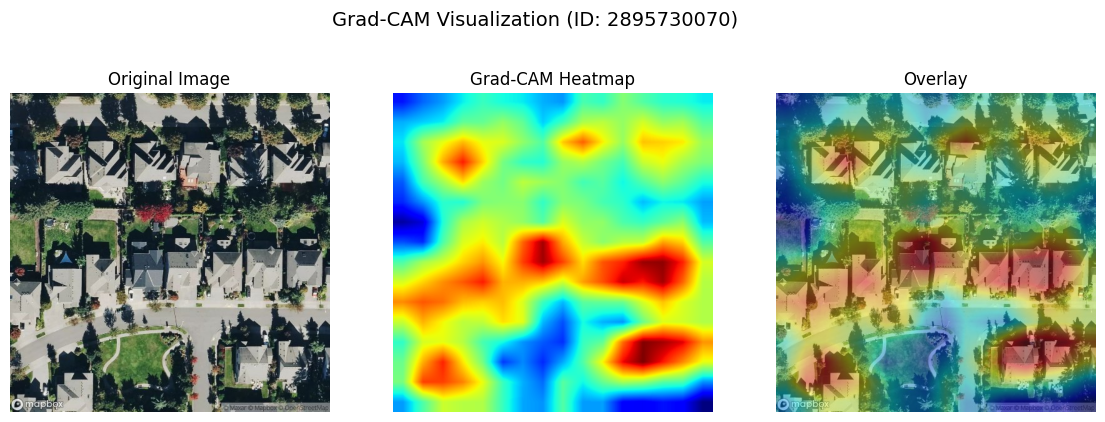

In [72]:
#top price +drivers
show_top_images_for_component(top_pos[0])

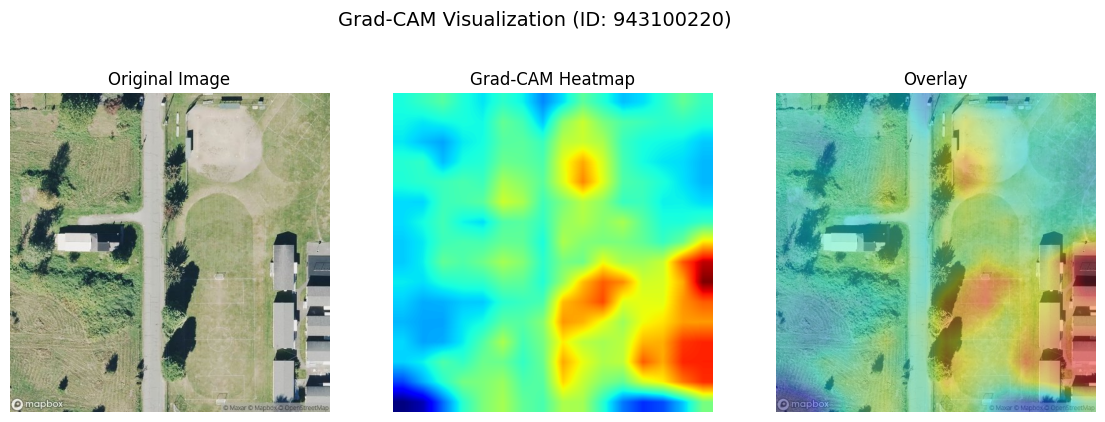

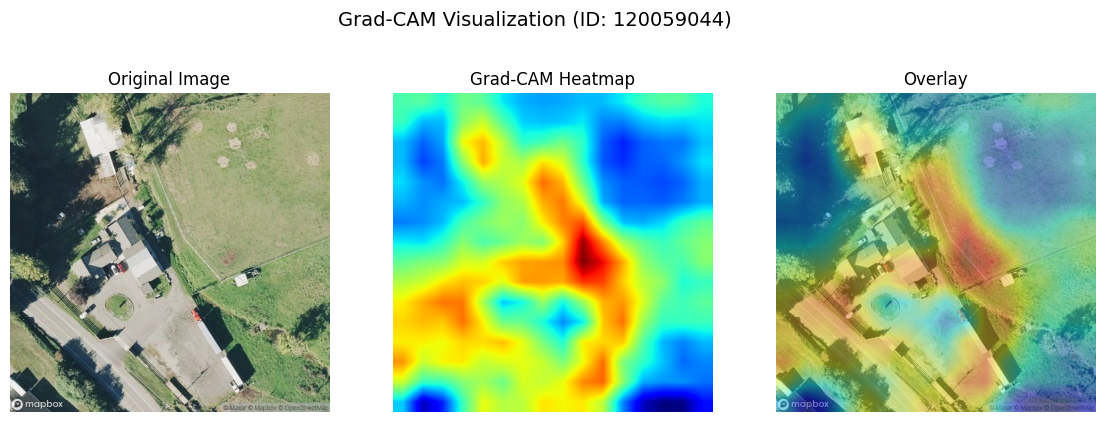

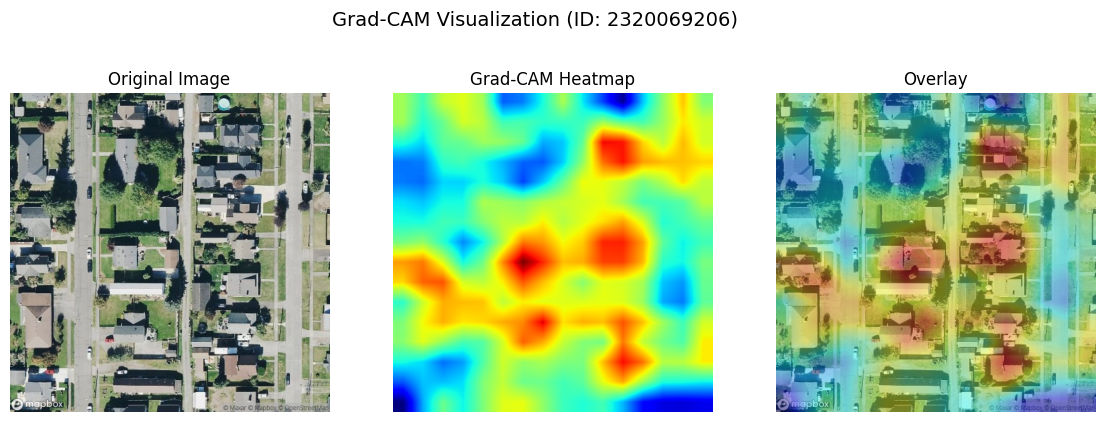

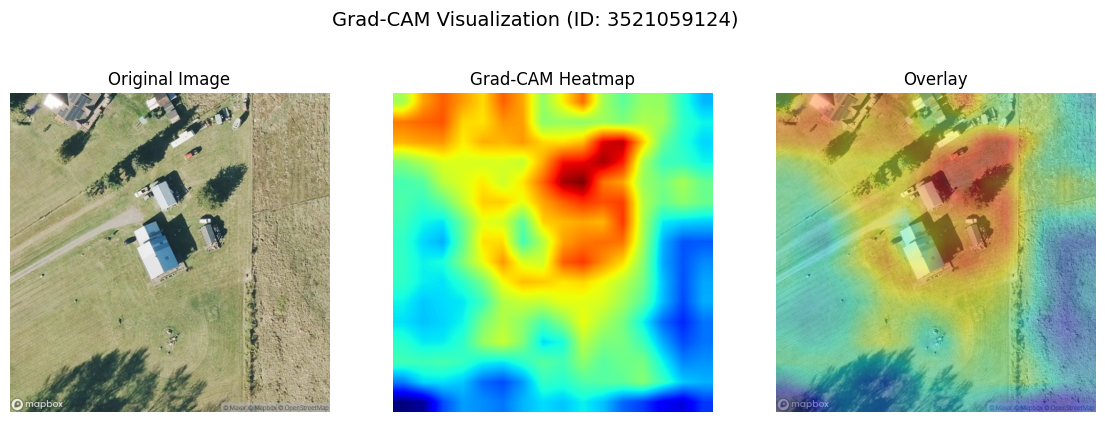

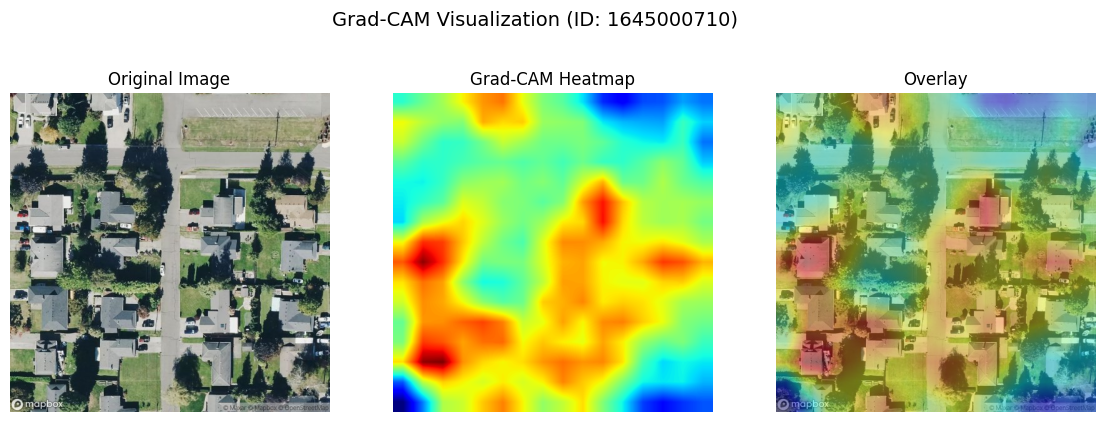

In [73]:
#top negative drivers
show_top_images_for_component(top_neg[0])

In [75]:
#get the requirements
!pip freeze > requirements.txt

#save
import shutil
shutil.copy('requirements.txt', f'{BASE_DIR}/model_training_notebook_requirements.txt')

'/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025/model_training_notebook_requirements.txt'

# 6.PREDICTION - on test data

In [ ]:
#generate embeddings
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/cdcxyhills_2025"

IMG_DIR_TEST  = Path(f"{BASE_DIR}/images/test")

TEST_CSV  = f"{BASE_DIR}/test(2).csv"

ROW_IDS_TEST  = f"{BASE_DIR}/test_df_row_ids.npy"

test_ids  = np.load(ROW_IDS_TEST)

generate_embeddings(test_ids,  IMG_DIR_TEST,  "img_test")

In [78]:
#as type str
img_test_ids = np.load(f"{BASE_DIR}/img_test_ids.npy").astype(str)
test_ids = test_ids.astype(str)

In [80]:
#sanity check
assert np.array_equal(img_test_ids, test_ids)

In [82]:
#load artifacts

# Tabular test features
X_test_tab = np.load(f"{BASE_DIR}/test_processed_tab.npy")

# Test image embeddings
img_test = np.load(f"{BASE_DIR}/img_test_emb.npy")

# Row IDs (for submission)
test_ids = np.load(f"{BASE_DIR}/test_df_row_ids.npy")

# PCA (180 dims)
pca = joblib.load(f"{BASE_DIR}/img_pca_180.pkl")

# Early Fusion model
xgb_early = joblib.load(f"{BASE_DIR}/xgb_early_fusion.pkl")


In [83]:
#apply pca
img_test_pca = pca.transform(img_test)

print(X_test_tab.shape, img_test_pca.shape)

(5404, 23) (5404, 180)


In [84]:
#sanity check
assert X_test_tab.shape[0] == img_test_pca.shape[0] == len(test_ids)

In [85]:
#early fusion matrix
X_test_fused = np.hstack([X_test_tab, img_test_pca])

In [86]:
# Predict (log scale)
y_test_log_pred = xgb_early.predict(X_test_fused)

# Back-transform to original price
y_test_pred = np.expm1(y_test_log_pred)

In [87]:
submission = pd.DataFrame({
    "id": test_ids.astype(str),
    "predicted_price": y_test_pred
})

submission.head()

id  predicted_price
0  2591820310     3.656501e+05
1  7974200820     8.050865e+05
2  7701450110     1.120747e+06
3  9522300010     1.822378e+06
4  9510861140     6.675425e+05

In [88]:
#save submission file
SUB_PATH = f"{BASE_DIR}/Submission.csv"
submission.to_csv(SUB_PATH, index=False)

In [89]:
#final check
assert submission.isnull().sum().sum() == 0
assert (submission["predicted_price"] >= 0).all()
assert submission.shape[0] == len(test_ids)
print('THANK YOU!')

THANK YOU!
